In [1]:
import os
import xarray as xr
import numpy as np
from tqdm import tqdm
from skimage.morphology import remove_small_objects
from skimage.measure import label as ski_label
from flox.xarray import xarray_reduce
from dask.distributed import Client, LocalCluster

input_path = '../../../data/cluster/input_sam_nadir'
output_path = '../../../data/cluster/output_sam'

infiles = sorted([f'{input_path}/{f}' for f in os.listdir(input_path)])
outfiles = sorted([f'{output_path}/{f}' for f in os.listdir(output_path) if 'T' in f and 'nc' not in f])


In [2]:

cluster = LocalCluster(
    n_workers=16,
    memory_limit='8GB'
)

client = Client(cluster)

/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45509 instead
  warnings.warn(


In [98]:
i = 12


key = infiles[i].split('/')[-1].split('_concat.nc')[0]
if os.path.exists(infiles[i]) and os.path.exists(f'{output_path}/{key}'):
    print(f'{key} exists: {len(os.listdir(f"{output_path}/{key}") )} output-files')

ds_in = xr.open_dataset(infiles[i], chunks='auto')
ds_out = xr.open_dataset(f'{output_path}/{key}_full.nc', chunks='auto')
ds_in['skin_t'] = ds_in['skin_t'] * .96 + .14
seg_map = ds_out['segmentation'].values
max_proba = ds_in[['cl_0', 'cl_1', 'cl_2']].interpolate_na(dim='x', method='linear').to_array()
max_proba = max_proba.pad(variable=(0, 1), constant_values=0)
max_proba['variable'] = np.array([0, 1, 2, 3])
max_proba = max_proba.argmax('variable').values
#max_proba = max_proba.where(max_proba != 3).values
smoothed_prediction = np.zeros_like(max_proba)

water_ice_mix = (ds_in['cl_0'] > .25 ) & (ds_in['cl_1'] > .25 )
cold_water = (ds_out['smoothed_prediction'] == 1) & (ds_out['skin_t'] < -3)
water_ice_mix = water_ice_mix | cold_water
ds_out['smoothed_prediction'] = ds_out['smoothed_prediction'].where(~water_ice_mix, 2)

for seg in np.unique(seg_map):
    uniques, counts = np.unique(max_proba[seg_map == seg], return_counts=True)
    most_occuring_label = uniques[np.argmax(counts)]
    smoothed_prediction[seg_map == seg] = most_occuring_label

ds_out['smoothed_prediction'] = xr.DataArray(smoothed_prediction + 1, dims=['y', 'x'])
ds_out['smoothed_prediction'] = xr.where(ds_out.smoothed_prediction == 2, 4, xr.where(ds_out.smoothed_prediction == 4, 2, ds_out.smoothed_prediction))

image = ds_out['smoothed_prediction'].values
label_image = ski_label(image, connectivity=2)

ds_out['label'] = xr.DataArray(label_image, dims=['y', 'x'])
ds_out['label'] = (('y', 'x'),remove_small_objects(ds_out['label'].values, min_size=1))


# Apply Flox-based aggregation
unique_ws = np.unique(ds_out['label'].values)

segment_area = xarray_reduce(ds_out['label'], ds_out['label'], func='count', engine='flox', expected_groups=unique_ws)
segment_T = xarray_reduce(ds_out['skin_t'], ds_out['label'], func='nanmean', engine='flox', expected_groups=unique_ws)
segment_std = xarray_reduce(ds_out['skin_t'], ds_out['label'], func='nanstd', engine='flox', expected_groups=unique_ws)
segment_label = xarray_reduce(ds_out['smoothed_prediction'], ds_out['label'], func='nanmode', engine='numpy', expected_groups=unique_ws)
segment_lat = xarray_reduce(ds_out['lat'], ds_out['label'], func='nanmean', engine='flox', expected_groups=unique_ws)
segment_lon = xarray_reduce(ds_out['lon'], ds_out['label'], func='nanmean', engine='flox', expected_groups=unique_ws)

# Store results in dataset
ds_segstats = xr.Dataset(
    data_vars={
        'segment_size': ('segment', segment_area.values),
        'segment_T': ('segment', segment_T.values),
        'segment_std': ('segment', segment_std.values),
        'segment_label': ('segment', segment_label.values),
        'segment_area': ('segment', segment_area.values),
        'segment_lat': ('segment', segment_lat.values),
        'segment_lon': ('segment', segment_lon.values),
    },
    coords={'segment': np.arange(len(segment_area))}
)

# Save results
ds_segstats_path = f'/projekt_agmwend/home_rad/Joshua/Mueller_et_al_2024/data/segmented_data_nadir/{key}.nc'
if not os.path.isfile(ds_segstats_path):
    ds_segstats.to_netcdf(ds_segstats_path)
    print('Saved segmentation statistics')

ds_full_path = f'/projekt_agmwend/home_rad/Joshua/Mueller_et_al_2024/data/cluster/output_sam/{key}_full.nc'
if not os.path.isfile(ds_full_path):
    ds_out.to_netcdf(ds_full_path.replace('cluster/output_sam', 'full_datasets'))
    print('Saved full dataset')



2022-04-01T13:36:00_2022-04-01T13:52:30 exists: 5 output-files


/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/dask/array/reductions.py:1113: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/dask/array/reductions.py:1113: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 112.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<Axes: xlabel='segment'>

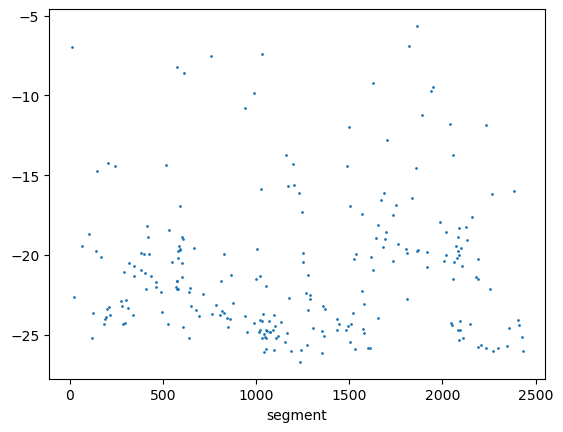

In [123]:
df_segstats.where(df_segstats.segment_label == 1)['segment_T'].plot(lw=0, marker='o', markersize=1)

<Axes: title={'center': 'segment_T'}, xlabel='segment_label'>

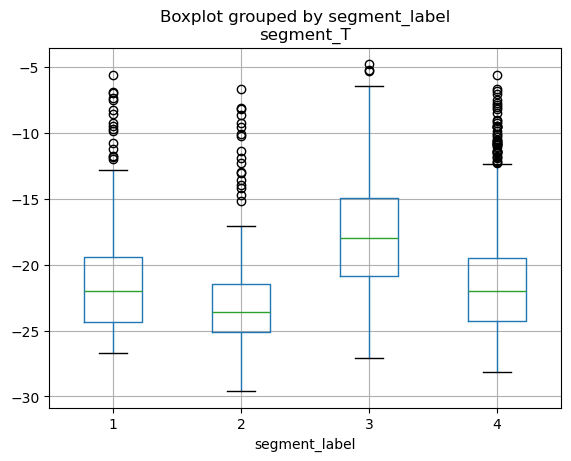

In [114]:
df_segstats = ds_segstats.to_dataframe()

df_segstats.boxplot(column='segment_T', by='segment_label')

<Axes: title={'center': 'segment_T'}, xlabel='segment_label'>

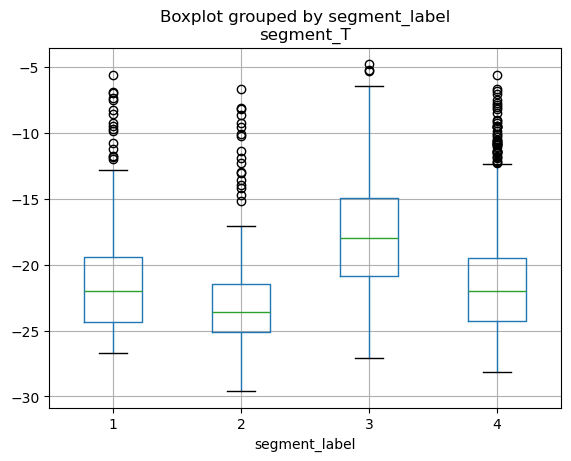

<Axes: xlabel='segment_lon', ylabel='segment_lat'>

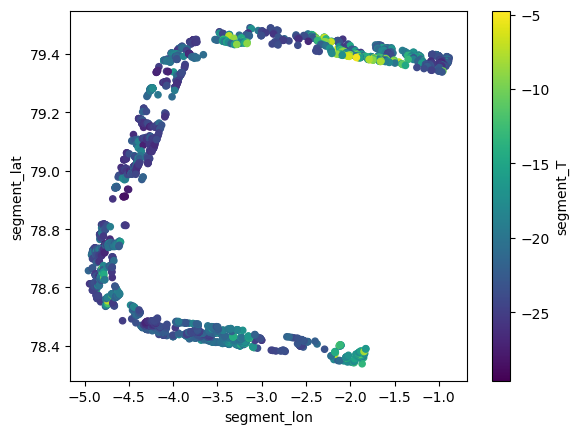

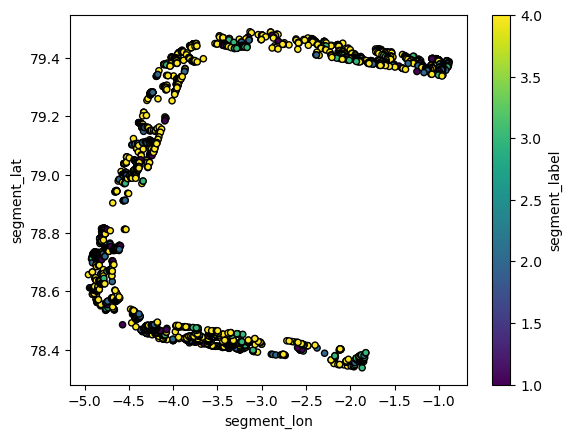

In [113]:
df_segstats.plot.scatter(x='segment_lon', y='segment_lat', c='segment_T', cmap='viridis', alpha=1)
df_segstats.plot.scatter(x='segment_lon', y='segment_lat', c='segment_label', cmap='viridis', alpha=1, edgecolor='k')

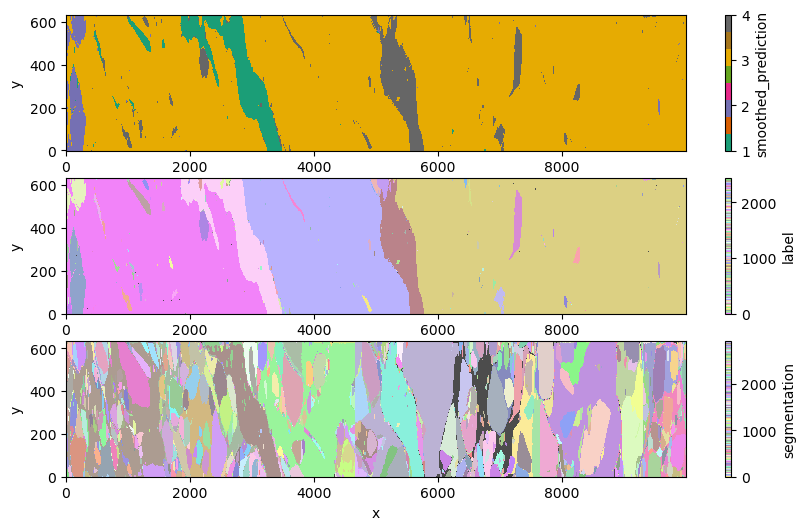

In [64]:
fig, ax = plt.subplots(3, figsize=(10, 6))
ds_out.smoothed_prediction.isel(x=slice(0, 10000)).plot.imshow(cmap='Dark2', ax=ax[0])
ds_out.label.isel(x=slice(0, 10000)).plot.imshow(cmap=cmap, ax=ax[1])
ds_out.segmentation.isel(x=slice(0, 10000)).plot.imshow(cmap=cmap, ax=ax[2])

In [63]:
ds_in['skin_t'].mean().compute()

<xarray.DataArray 'skin_t' ()>
array(-23.036049, dtype=float32)

/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/dask/array/reductions.py:1113: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/dask/array/reductions.py:1113: RuntimeWarning: All-NaN slice encountered
  vals = func(x, axis=arg_axis, keepdims=True)


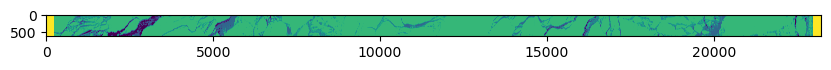

In [23]:
import matplotlib.pyplot as plt

seg_map = ds_out['segmentation'].values
max_proba = ds_in[['cl_0', 'cl_1', 'cl_2']].interpolate_na(dim='x', method='linear').to_array()
max_proba = max_proba.pad(variable=(0, 1), constant_values=0)
max_proba['variable'] = np.array([0, 1, 2, 3])
max_proba = max_proba.argmax('variable').values

plt.figure(figsize=(10, 2))
plt.imshow(max_proba, cmap='viridis')

100%|██████████| 1888/1888 [00:53<00:00, 35.01it/s]


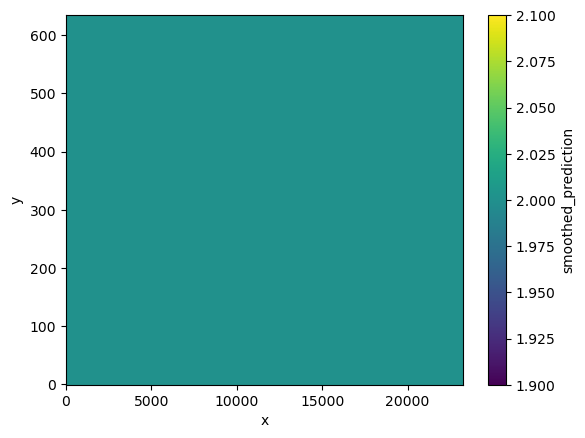

In [14]:
from tqdm import tqdm   
smoothed_prediction = np.zeros_like(max_proba)

water_ice_mix = (ds_in['cl_0'] > .5 ) & (ds_in['cl_1'] > .25 )
cold_water = (ds_out['smoothed_prediction'] == 1) & (ds_out['skin_t'] < -3)
water_ice_mix = water_ice_mix | cold_water
ds_out['smoothed_prediction'] = ds_out['smoothed_prediction'].where(~water_ice_mix, 2)

for seg in tqdm(np.unique(seg_map)):
    uniques, counts = np.unique(max_proba[seg_map == seg], return_counts=True)
    most_occuring_label = uniques[np.argmax(counts)]
    smoothed_prediction[seg_map == seg] = most_occuring_label

ds_out['smoothed_prediction'] = xr.DataArray(smoothed_prediction + 1, dims=['y', 'x'])
ds_out['smoothed_prediction'] = xr.where(ds_out.smoothed_prediction == 2, 4, xr.where(ds_out.smoothed_prediction == 4, 2, ds_out.smoothed_prediction))

ds_out['smoothed_prediction'].plot()

<xarray.Dataset>
Dimensions:        (segment_label: 4)
Coordinates:
  * segment_label  (segment_label) int64 1 2 3 4
Data variables:
    segment_size   (segment_label) float64 49.0 64.5 116.0 51.0
    segment_T      (segment_label) float64 -22.68 -23.6 -17.44 -21.37
    segment_std    (segment_label) float64 0.8076 0.621 1.074 0.7741
    segment_area   (segment_label) float64 49.0 64.5 116.0 51.0

<xarray.Dataset>
Dimensions:        (segment: 76)
Coordinates:
  * segment        (segment) int64 7 14 56 66 67 70 ... 677 685 703 712 716 724
Data variables:
    segment_size   (segment) int64 281037 309 41 110 449 16 ... 53 66 100 16 56
    segment_T      (segment) float32 -6.952 -22.61 -19.46 ... -24.36 -25.13
    segment_std    (segment) float32 2.372 1.531 0.6683 ... 0.5736 0.5069 0.507
    segment_label  (segment) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    segment_area   (segment) int64 281037 309 41 110 449 16 ... 53 66 100 16 56
<xarray.Dataset>
Dimensions:        (segment: 84)
Coordinates:
  * segment        (segment) int64 1 3 5 39 45 46 47 ... 656 657 682 684 710 717
Data variables:
    segment_size   (segment) int64 3992 70639 83 4750 135 ... 644 157 20 25 35
    segment_T      (segment) float32 -22.94 -24.9 -23.14 ... -24.26 -26.0 -25.29
    segment_std    (segment) float32 1.706 1.187 0.8374 ... 0.5649 0.5056 0.5962
    segment_label  (segment) int64 2 2 2 2 

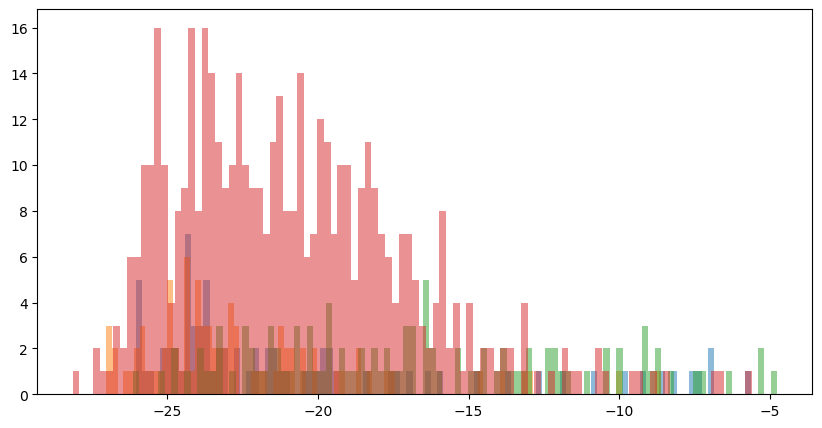

In [53]:
ds_gp = ds_segstats.groupby('segment_label')
### plot the mean temperature of each segment as histogram

plt.figure(figsize=(10, 5))

for label, group in ds_gp:
    print(group)
    plt.hist(group['segment_T'], bins=100, alpha=.5, label=f'{label}')



In [75]:
ds_in['skin_t'].shape, ds_out['skin_t'].shape

((635, 23226), (635, 23226))

In [36]:
from matplotlib.colors import ListedColormap
# Generate random RGB values for each segment
def random_cmap(nlabels, seed=12):
    np.random.seed(seed)
    rand_colors = np.random.rand(nlabels, 3)
    pastel_colors = (rand_colors + np.ones((nlabels, 3))) / 2  # Blend with white for pastel
    pastel_colors[0] = [0.3, 0.3, 0.3]  # Set background (label 0) to a light gray
    return ListedColormap(pastel_colors)


cmap = random_cmap(ds_out['label'].max().values + 1)

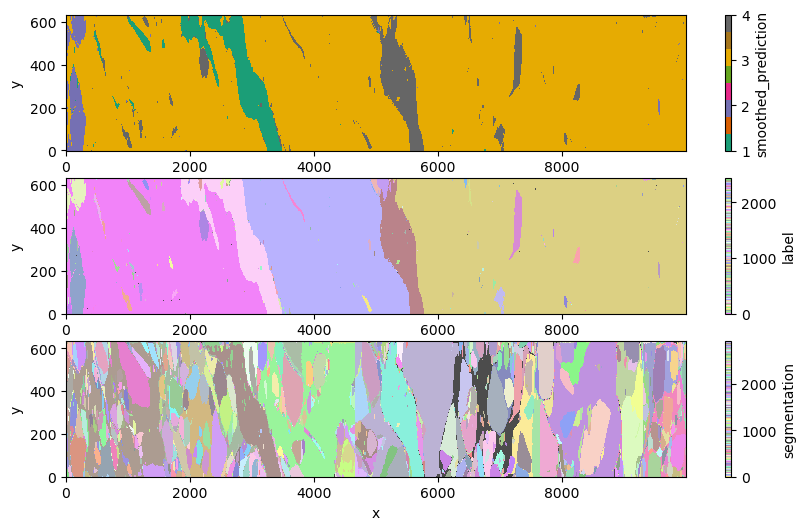

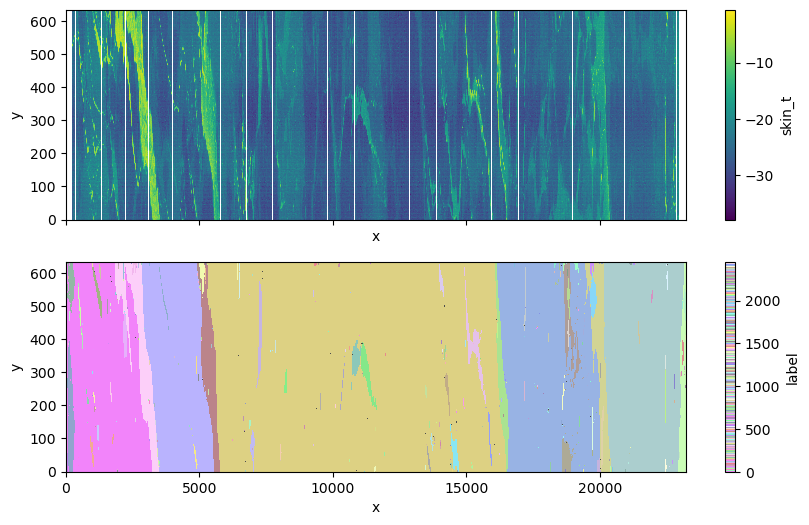

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].set_xlim(0, 1000)

ds_in['skin_t'].plot(ax=ax[0])
ds_out['label'].plot(ax=ax[1], cmap=cmap)

In [59]:
ds_out['smoothed_prediction']

<xarray.DataArray 'smoothed_prediction' (y: 635, x: 23226)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 4.,  4.,  4., ...,  3.,  3.,  3.],
       [ 4.,  4.,  4., ...,  3.,  3.,  3.],
       [ 4.,  4.,  4., ...,  3.,  3.,  3.]])
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 626 627 628 629 630 631 632 633 634
  * x        (x) int64 0 1 2 3 4 5 6 ... 23220 23221 23222 23223 23224 23225

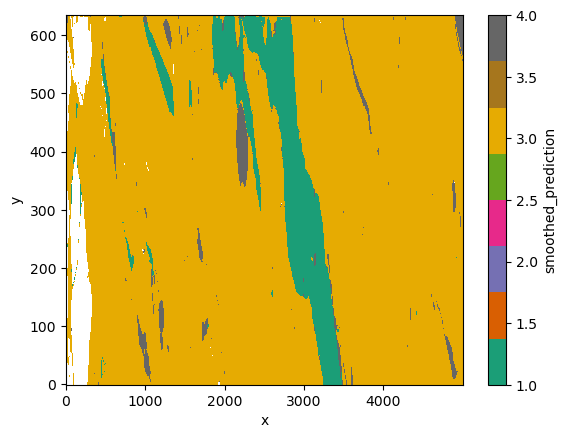

In [64]:
ds_out['smoothed_prediction'].isel(x=slice(0, 5000)).plot(cmap='Dark2', add_colorbar=True)

